In [1]:
import numpy as np, pandas as pd, polars as pl
from sklearn.model_selection import KFold
from sklearn import preprocessing as skp
from sklearn.decomposition import PCA 
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error as rmse
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv', index_col = 'id')
test = pd.read_csv('test.csv', index_col = 'id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 68.7+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  object 
 1   Episode_Title                250000 non-null  object 
 2   Episode_Length_minutes       221264 non-null  float64
 3   Genre                        250000 non-null  object 
 4   Host_Popularity_percentage   250000 non-null  float64
 5   Publication_Day              250000 non-null  object 
 6   Publication_Time             250000 non-null  object 
 7   Guest_Popularity_percentage  201168 non-null  float64
 8   Number_of_Ads                250000 non-null  float64
 9   Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), object(6)
memory usage: 21.0+ MB


In [5]:
categorical_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6, # Day

        'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3,                                            # Time

        'Negative': 0, 'Neutral': 1, 'Positive': 2,                                                        # Sentiment

        'True Crime': 0, 'Comedy': 1, 'Education': 2, 'Technology': 3, 'Health': 4, 'News': 5, 'Music': 6, # Genre
        'Sports': 7, 'Business': 8, 'Lifestyle': 9
        }

categories = ['Genre', 'Podcast_Name', 'Episode_Title', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

In [6]:
podcast = {}
for i, n in enumerate(train['Podcast_Name'].unique()):
    podcast[n] = i

categorical_map.update(podcast)

In [7]:
train['Episode_Title'] = train['Episode_Title'].str[8:]
test['Episode_Title'] = test['Episode_Title'].str[8:]

In [8]:
train = train.replace(categorical_map).fillna(0)
test = test.replace(categorical_map).fillna(0)

In [9]:
x = train.drop('Listening_Time_minutes', axis=1)
y = train['Listening_Time_minutes']

In [10]:
poly = skp.PolynomialFeatures(interaction_only=True, include_bias=False)
x_poly = poly.fit_transform(x)
test_poly = poly.fit_transform(test)

In [11]:
cols = poly.get_feature_names_out(x.columns)
x = pd.DataFrame(x_poly, columns=cols)

test_cols = poly.get_feature_names_out(test.columns)
test = pd.DataFrame(test_poly, columns=test_cols)

In [12]:
for c in categories: 
    x[c] = x[c].astype('category')
    test[c] = test[c].astype('category')

In [13]:
K = 3
kf = KFold(K, shuffle=True, random_state=55)

In [14]:
pred = pd.DataFrame()
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [15]:
for train_idx, val_idx in kf.split(x,y):
    x_t, y_t = x.iloc[train_idx], y.iloc[train_idx]
    x_v, y_v = x.iloc[val_idx], y.iloc[val_idx]
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse', enable_categorical = True, device = 'cuda', tree_method="hist")#, min_child_weight=4)
    model.fit(x_t, y_t, eval_set=[(x_v,y_v)])
    pred = pd.concat([pd.DataFrame(model.predict(test)), pred], axis=1)
    weight = model.get_booster().get_score(importance_type='weight')
    gain = model.get_booster().get_score(importance_type='total_gain')
    fi_dict = {'x': x.columns, 'importance': model.feature_importances_}
    fi_df = pd.DataFrame(fi_dict).sort_values(by='x')
    weight = pd.DataFrame(sorted(weight.items()))
    gain = pd.DataFrame(sorted(gain.items()))

[0]	validation_0-rmse:21.21501
[1]	validation_0-rmse:17.61298
[2]	validation_0-rmse:15.53115
[3]	validation_0-rmse:14.39418
[4]	validation_0-rmse:13.79195
[5]	validation_0-rmse:13.47590
[6]	validation_0-rmse:13.31154
[7]	validation_0-rmse:13.22468
[8]	validation_0-rmse:13.17613
[9]	validation_0-rmse:13.14977
[10]	validation_0-rmse:13.13323
[11]	validation_0-rmse:13.12482
[12]	validation_0-rmse:13.12126
[13]	validation_0-rmse:13.11649
[14]	validation_0-rmse:13.11496
[15]	validation_0-rmse:13.11337
[16]	validation_0-rmse:13.10926
[17]	validation_0-rmse:13.10797
[18]	validation_0-rmse:13.10417
[19]	validation_0-rmse:13.10143
[20]	validation_0-rmse:13.10065
[21]	validation_0-rmse:13.10009
[22]	validation_0-rmse:13.09861
[23]	validation_0-rmse:13.09695
[24]	validation_0-rmse:13.09719
[25]	validation_0-rmse:13.09936
[26]	validation_0-rmse:13.09812
[27]	validation_0-rmse:13.09747
[28]	validation_0-rmse:13.09523
[29]	validation_0-rmse:13.09518
[30]	validation_0-rmse:13.09613
[31]	validation_0-

c:\Users\evan\anaconda3\lib\site-packages\xgboost\core.py:729: UserWarning: [17:31:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[0]	validation_0-rmse:21.19995
[1]	validation_0-rmse:17.59004
[2]	validation_0-rmse:15.49987
[3]	validation_0-rmse:14.35327
[4]	validation_0-rmse:13.74305
[5]	validation_0-rmse:13.42587
[6]	validation_0-rmse:13.25440
[7]	validation_0-rmse:13.16610
[8]	validation_0-rmse:13.11783
[9]	validation_0-rmse:13.09246
[10]	validation_0-rmse:13.07393
[11]	validation_0-rmse:13.06201
[12]	validation_0-rmse:13.05532
[13]	validation_0-rmse:13.05118
[14]	validation_0-rmse:13.04937
[15]	validation_0-rmse:13.04737
[16]	validation_0-rmse:13.04453
[17]	validation_0-rmse:13.04133
[18]	validation_0-rmse:13.04006
[19]	validation_0-rmse:13.04209
[20]	validation_0-rmse:13.04090
[21]	validation_0-rmse:13.03978
[22]	validation_0-rmse:13.03725
[23]	validation_0-rmse:13.03615
[24]	validation_0-rmse:13.03636
[25]	validation_0-rmse:13.03618
[26]	validation_0-rmse:13.03642
[27]	validation_0-rmse:13.03387
[28]	validation_0-rmse:13.03378
[29]	validation_0-rmse:13.03190
[30]	validation_0-rmse:13.03207
[31]	validation_0-

In [16]:
missing = set(fi_df['x']) - set(weight[0])
print(missing)

{'Podcast_Name Genre', 'Genre'}


In [17]:
fi_df.drop([3,12], inplace=True)
fi_df['x'].info()

<class 'pandas.core.series.Series'>
Index: 53 entries, 2 to 50
Series name: x
Non-Null Count  Dtype 
--------------  ----- 
53 non-null     object
dtypes: object(1)
memory usage: 848.0+ bytes


In [18]:
bars = pd.DataFrame(np.vstack([weight[1], gain[1], fi_df['importance']]), columns=gain[0], index=['weight','total gain', 'feature importance'])
#bars = pd.DataFrame(np.rot90(np.vstack([weight[1], gain[1], fi_df['importance']])), index=gain[0], columns=['weight','total gain', 'feature importance'])

In [ ]:
bars

,Episode_Length_minutes,Episode_Length_minutes Episode_Sentiment,Episode_Length_minutes Genre,Episode_Length_minutes Guest_Popularity_percentage,Episode_Length_minutes Host_Popularity_percentage,Episode_Length_minutes Number_of_Ads,Episode_Length_minutes Publication_Day,Episode_Length_minutes Publication_Time,Episode_Sentiment,Episode_Title,...,Podcast_Name Publication_Time,Publication_Day,Publication_Day Episode_Sentiment,Publication_Day Guest_Popularity_percentage,Publication_Day Number_of_Ads,Publication_Day Publication_Time,Publication_Time,Publication_Time Episode_Sentiment,Publication_Time Guest_Popularity_percentage,Publication_Time Number_of_Ads
weight,4.310000e+02,92.000000,43.000000,131.00000,2.390000e+02,78.000000,91.00000,72.000000,6.000000,2.103000e+03,...,10.000000,63.00000,13.000000,35.000000,12.000000,14.000000,18.000000,7.000000,31.000000,7.000000
total gain,4.892746e+08,634404.000000,89650.414062,585013.56250,3.165946e+06,464922.343750,302838.71875,219159.140625,38816.968750,1.449070e+07,...,24264.369141,282445.93750,48227.921875,94216.710938,155411.812500,34721.820312,54441.082031,15990.226562,94149.937500,26370.097656
feature importance,6.482457e-01,0.003938,0.001191,0.00255,7.564319e-03,0.003404,0.00190,0.001738,0.003694,3.934726e-03,...,0.001386,0.00256,0.002118,0.001537,0.007395,0.001416,0.001727,0.001304,0.001734,0.002151


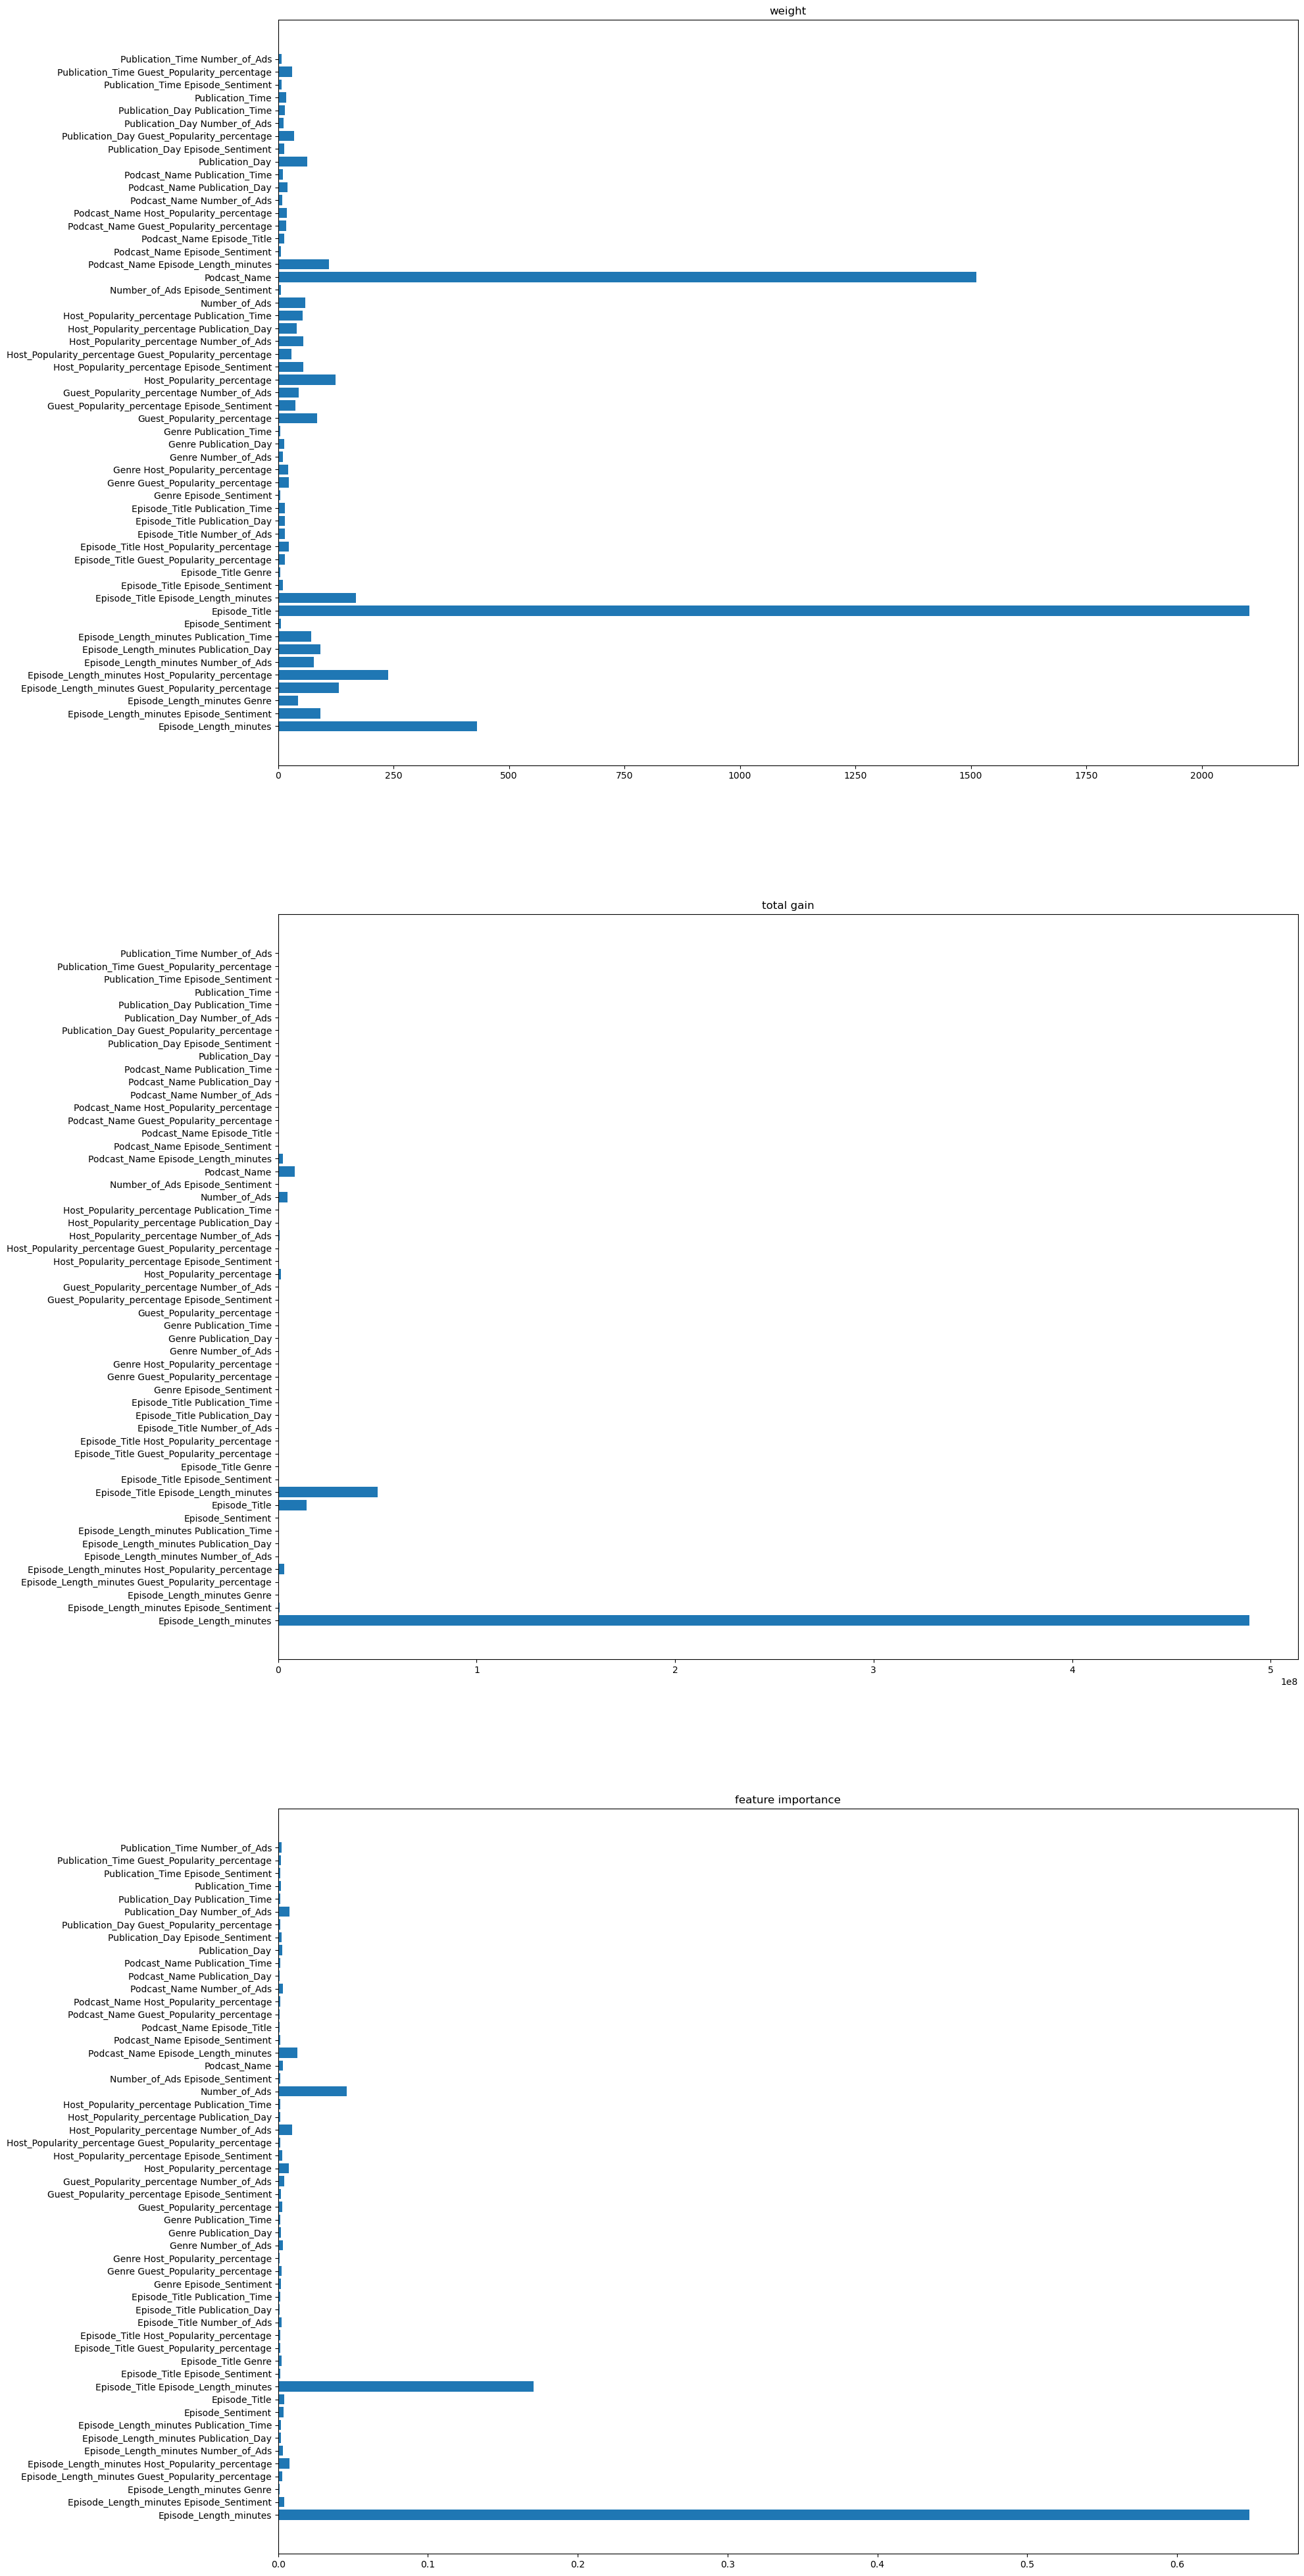

In [23]:
fig, ax = plt.subplots(3, figsize=(20,50))
ax[0].barh(bars.columns, bars.iloc[0,:]) #sns.barplot(data=bars.iloc[0,:], orient='y', width=1, errorbar=None, color='r')
ax[1].barh(bars.columns, bars.iloc[1,:]) #sns.barplot(data=bars.iloc[1,:], orient='y', width=1, errorbar=None, color='b')
ax[2].barh(bars.columns, bars.iloc[2,:]) #sns.barplot(data=bars.iloc[2,:], orient='y', width=1, errorbar=None, color='y')
ax[0].set_title('weight')
ax[1].set_title('total gain')
ax[2].set_title('feature importance')
#ax.bar_label(ax.containers[0], fontsize=10, padding=2)
plt.show()

In [26]:
gain.sort_values(by=1, ascending=False)

,0,1
0,Episode_Length_minutes,4.892746e+08
10,Episode_Title Episode_Length_minutes,5.019189e+07
9,Episode_Title,1.449070e+07
35,Podcast_Name,8.414402e+06
33,Number_of_Ads,4.710836e+06
4,Episode_Length_minutes Host_Popularity_percentage,3.165946e+06
36,Podcast_Name Episode_Length_minutes,2.483736e+06
27,Host_Popularity_percentage,1.523596e+06
30,Host_Popularity_percentage Number_of_Ads,9.058190e+05
1,Episode_Length_minutes Episode_Sentiment,6.344040e+05


In [ ]:
pred.reset_index(drop=True, inplace=True)
pred.index += 750000
pred_sum = pred.sum(axis=1) / K

In [ ]:
pred.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
750000,52.422321,52.161697,52.887894,53.774200,53.656181,53.514206,53.341064,54.078854,52.930553,52.063507,...,52.096928,54.374897,52.739147,53.164509,51.267963,51.915543,54.571411,54.525528,54.800144,54.264595
750001,18.618940,18.313286,18.225765,18.258863,18.470175,18.167280,17.675730,18.523539,18.341600,17.102133,...,17.817486,17.623583,18.589970,19.009201,18.661680,18.220932,18.621820,18.428267,18.445499,18.393614
750002,49.408112,50.371239,48.327209,48.148037,48.922752,48.777225,47.703999,48.212605,49.463329,49.633575,...,49.737312,49.978252,47.920681,46.594982,49.707146,49.549095,49.720924,49.119438,49.751686,50.421898
750003,78.056595,80.410545,83.023750,79.001389,82.482407,80.813400,78.928375,79.774796,75.693535,83.510269,...,76.436401,79.674911,79.389191,77.818634,82.324066,81.756889,78.519585,81.700142,78.213562,80.849266
750004,49.724411,49.096329,48.715485,48.357048,48.951626,49.196938,47.605820,49.398361,48.267700,49.117085,...,49.732430,49.098606,48.171635,48.400120,49.263012,49.253521,48.492901,49.603424,48.799591,49.454044


In [ ]:
pred_sum.rename('Listening_Time_minutes', inplace=True)
pred_sum.head()

750000    53.340137
750001    18.317774
750002    49.138416
750003    80.038475
750004    48.960129
Name: Listening_Time_minutes, dtype: float32

In [ ]:
pred_sum.to_csv('submission_2.csv', index_label='id')